# Importing Dependencies and reading the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Built in modules
import os
import json
import pickle
import math
# Python Frameworks
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Machine Learning Frameworks
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from sklearn.model_selection import train_test_split

Go to the directory where dataset is saved

In [3]:
os.chdir('/content/drive/MyDrive/Recipe-NER')

Create a pandas dataframe from the dataset

In [4]:
df = pd.read_csv('dataset.csv')
# Check what the dataset looks like
df.head()

,Example #,Word,Label,Start,End
0,0,combine,O,0,7
1,0,the,O,8,11
2,0,paprika,B-IN,12,19
3,0,oregano,B-IN,20,27
4,0,thyme,B-IN,28,33


In [5]:
# Get the label distribution for non-O labels
label_dist = df['Label'].value_counts()[1:]
# Print the label distribution  
print(label_dist)
non_o_labels_count = sum(label_dist)
# Number of labels with an annotation
print("Total count of words with non-O labels: ", non_o_labels_count)

B-IN    5802
B-CO    1777
I-IN    1349
I-TI     670
B-TI     629
B-ME     490
I-ME     414
I-CO     376
B-TE     144
B-AD      50
I-AD      18
I-TE       3
Name: Label, dtype: int64
Total count of words with non-O labels:  11722


Visualize the distribution of labels

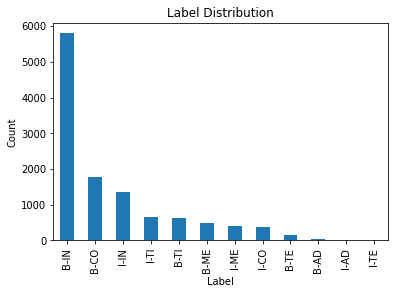

In [6]:
# Create the bar chart
label_dist.plot(kind='bar')

# Add a title and axis labels
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

# Show the chart
plt.show()

# Preprocessing and setting up variables required for the Neural Network




Since the labels with the value AD(Add-ons) are very small compared to the other labels it might be best to ignore them for this model.


In [7]:
ignore = ['B-AD', 'I-AD']
df['Label'] = df['Label'].replace(ignore, 'O')
label_dist = df['Label'].value_counts()[1:]
print(label_dist)
non_o_labels_count = sum(label_dist)
print("Updated total count of words with non-O labels after ignoring certain tags: ", non_o_labels_count)

B-IN    5802
B-CO    1777
I-IN    1349
I-TI     670
B-TI     629
B-ME     490
I-ME     414
I-CO     376
B-TE     144
I-TE       3
Name: Label, dtype: int64
Updated total count of words with non-O labels after ignoring certain tags:  11654


Number of Unique Words


In [8]:
words = list(set(list(df['Word'].values)))
n_words = len(words)
n_words

2115

In [9]:
tags = list(set(df["Label"].values))

# Save the list to a file for inference
with open("tags", "wb") as fp:  
  pickle.dump(tags, fp)
# Load the file to make sure it was saved
with open("tags", "rb") as fp:   
    tags = pickle.load(fp)


Number of tags

In [10]:
n_tags = len(tags)
n_tags

11

The class object is used to get the datapoints grouped into a list of list containing tupples. The data is grouped by example number, then all the words and corresponding labels are placed in a tupple. 

In [11]:
class ExampleGetter(object):
    def __init__(self, data):
        self.data = data
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(), s["Label"].values.tolist())]
        self.grouped = self.data.groupby("Example #").apply(agg_func)
        self.examples = [s for s in self.grouped]

In [12]:
getter = ExampleGetter(df)
examples = getter.examples

In [13]:
print("The number of examples in the training set:", len(examples))
max_len = max([len(examples[i]) for i in range(len(examples))])
print("The longest sentence has {} words".format(max_len))

The number of examples in the training set: 300
The longest sentence has 888 words


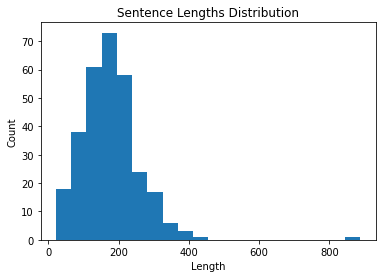

In [14]:
# Create the Histogram Chart
plt.hist([len(example) for example in examples], bins= 20)


# Add a title and axis labels
plt.title('Sentence Lengths Distribution')
plt.ylabel('Count')
plt.xlabel('Length')

# Show the chart
plt.show()

In [15]:
def roundup(x):
  # Rounds up to the nearest hundreds
  return int(math.ceil(x / 100.0)) * 100

In [16]:
max_len = roundup(max_len)
print(max_len)

900


Categorical data is converted to numerical data to make it easier for the neural network to learn

In [17]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
# Save the dictionary to a json file for inference
with open("word2idx.json", "w") as outfile:
  json.dump(word2idx, outfile)
# Load the file to make sure it was saved
with open('word2idx.json', 'r') as fcc_file:
    word2idx = json.load(fcc_file)

In [18]:
tag2idx = {t: i for i, t in enumerate(tags)}
# Save the dictionary to a json file for inference
with open("tag2idx.json", "w") as outfile:
  json.dump(tag2idx, outfile)
# Load the file to make sure it was saved
with open('tag2idx.json', 'r') as fcc_file:
    tag2idx = json.load(fcc_file)

In [19]:
mapping_dict = {
              'word2idx': word2idx,
              'tag2idx': tag2idx,
              'tags': tags
              }

In [20]:
with open("mapping.json", "w") as outfile:
    json.dump(mapping_dict, outfile)

In [21]:
with open('mapping.json', 'r') as fcc_file:
    mapping_dict = json.load(fcc_file)

word2idx = mapping_dict['word2idx']
tag2idx = mapping_dict['tag2idx']
tags = mapping_dict['tags']

Padding is done to make the data have a constant length, since neural networks require the same input sizes

In [22]:
X = [[word2idx[w[0]] for w in s] for s in examples]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

In [23]:
y = [[tag2idx[w[1]] for w in s] for s in examples]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

The function to_categorical was used on y, since the neural network to be used is Categorical Crossentropy

In [24]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

Split the dataset into training and testing, with 15% of the dataset being used for testing

In [25]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.15)

# Machine Learning




Model Architechture used for the Deep Learning Model

In [26]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(n_words+1, 2048, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=512, activation='tanh', return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, activation='tanh', return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, activation='tanh', return_sequences=True)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(256)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_tags, activation='softmax'))
])

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 900, 2048)         4333568   
                                                                 
 bidirectional (Bidirectiona  (None, 900, 1024)        10489856  
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 900, 512)         2623488   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 900, 256)         656384    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 900, 256)         65792     
 ibuted)                                                

Train the neural network using gpu. 15% of the training set will be set aside to be used for validation.

In [28]:
with tf.device('/GPU:0'):
  history = model.fit(X_tr, np.array(y_tr), batch_size=16, epochs=30, validation_split=0.15, verbose=1)

Epoch 1/30
14/14 [==============================] - 22s 721ms/step - loss: 0.5636 - accuracy: 0.8835 - val_loss: 0.2075 - val_accuracy: 0.9568
Epoch 2/30
14/14 [==============================] - 8s 592ms/step - loss: 0.1973 - accuracy: 0.9553 - val_loss: 0.1650 - val_accuracy: 0.9572
Epoch 3/30
14/14 [==============================] - 8s 606ms/step - loss: 0.1683 - accuracy: 0.9564 - val_loss: 0.1516 - val_accuracy: 0.9586
Epoch 4/30
14/14 [==============================] - 8s 596ms/step - loss: 0.1558 - accuracy: 0.9571 - val_loss: 0.1440 - val_accuracy: 0.9592
Epoch 5/30
14/14 [==============================] - 8s 606ms/step - loss: 0.1460 - accuracy: 0.9579 - val_loss: 0.1337 - val_accuracy: 0.9602
Epoch 6/30
14/14 [==============================] - 9s 612ms/step - loss: 0.1330 - accuracy: 0.9593 - val_loss: 0.1189 - val_accuracy: 0.9620
Epoch 7/30
14/14 [==============================] - 8s 608ms/step - loss: 0.1095 - accuracy: 0.9641 - val_loss: 0.0862 - val_accuracy: 0.9723
Epoch

Save the model for Inference

In [29]:
model.save('ner_model_30e.h5')

<Figure size 1728x1728 with 0 Axes>

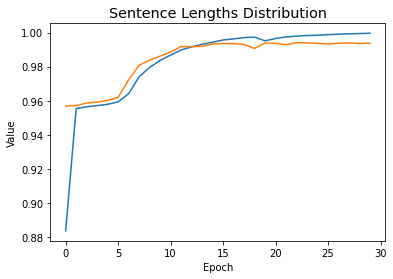

<Figure size 1728x1728 with 0 Axes>

In [30]:
# Create the Histogram Chart
hist = pd.DataFrame(history.history)
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.style.use("ggplot")

# Add a title and axis labels
plt.title('Sentence Lengths Distribution')
plt.ylabel('Value')
plt.xlabel('Epoch')



# Show the chart
plt.figure(figsize=(24, 24))

# Inference and Model Evaluation

Load the trained Model

In [31]:
loaded_model = tf.keras.models.load_model('ner_model_30e.h5')

co stands for cookware

te stands for temperature

in stands for ingredient

me stands for measurement

ti stands for time

O stands for no label

In [32]:
truth_table = ["true_positive", "false_positive", "false_negative"]
# Create the confusion matrix to be used to compute evaluation metrics
confusion_matrix_dict = {tag_idx:{truth_table_idx:0 for truth_table_idx in truth_table} for tag_idx in tag2idx.keys()}

for i in range(len(X_te)):
  # p stands for the probabilities predicted by the model on the input text
  p = loaded_model.predict(np.array([X_te[i]]))
  # Returns an array of the classes with the max probabilities of the prediction
  p = np.argmax(p, axis=-1)
  # Returns the labels on the words that were manually labelled
  true = np.argmax(y_te[i], -1)
  print("{}||{}||{}".format("Word", "True", "Pred"))
  print(30 * "=")
  for w, t, pred in zip(X_te[i], true, p[0]):
      if w != 0:
          print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))
          if tags[pred] ==  tags[t]:
            # Count of true positive increases when the prediction of the model is the same as the tag that was manually labelled 
            confusion_matrix_dict[tags[pred]]["true_positive"] += 1
          elif tags[pred] != tags[t]:
            # Count of false positive for the predicted tag increases
            confusion_matrix_dict[tags[pred]]["false_positive"] += 1
            # Count of false negative for the ground truth tag increases
            confusion_matrix_dict[tags[t]]["false_negative"] += 1

          

Streaming output truncated to the last 5000 lines.
paper          : I-IN  I-IN
for            : O     O
easy           : O     O
cleanup        : O     O
if             : O     O
desired        : O     O
drizzle        : O     O
the            : O     O
olive          : B-IN  B-IN
oil            : I-IN  I-IN
over           : O     O
the            : O     O
radishes       : B-IN  O
then           : O     O
add            : O     O
the            : O     O
salt           : B-IN  B-IN
pepper         : B-IN  B-IN
and            : O     O
garlic         : B-IN  B-IN
powder         : I-IN  I-IN
toss           : O     O
the            : O     O
radishes       : B-IN  O
until          : O     O
theyre         : O     O
coated         : O     O
in             : O     O
oil            : B-IN  B-IN
and            : O     O
seasoning      : B-IN  B-IN
transfer       : O     O
the            : O     O
seasoned       : O     O
radishes       : B-IN  O
to             : O     O
the            : O    

Combine Values for the different classes

In [33]:
metrics_dict = {}
for tag, metrics in confusion_matrix_dict.items():
  # Get the string after the second letter
  label = tag[2:]
  # 'O' will have a value of '' after applying the string indexing above
  if label == "":
    metrics_dict['O'] = metrics
  # Initialize the key value pair if it does not exist in metrics_dict
  elif label not in metrics_dict.keys():
    metrics_dict[label] = metrics
  else:
    # Combine the different labels values
    for metric, value in metrics.items():
      metrics_dict[label][metric] += value


In [34]:
machine_learning_metrics = ["Precision", "Recall", "f1_score"]
NER_metrics = {}
for tag, metrics in metrics_dict.items():
  for metric, value in metrics.items():
    tp = metrics_dict[tag]["true_positive"]
    fp = metrics_dict[tag]["false_positive"]
    fn = metrics_dict[tag]["false_negative"]
    # Compute for the model's precision, recall, and f1_score
    precision = round(tp/(tp+fp), 2)
    recall = round(tp/(tp+fn), 2)
    f1_score = round((2*(precision*recall))/(precision+recall), 2)
  # Create a dictionary that contains each performance metric for each tag in the trained model
  NER_metrics[tag] = {"Precision": precision, "Recall": recall, "F1_Score": f1_score}

In [35]:
print(json.dumps(NER_metrics,sort_keys=True, indent=4))

{
    "CO": {
        "F1_Score": 0.83,
        "Precision": 0.86,
        "Recall": 0.81
    },
    "IN": {
        "F1_Score": 0.83,
        "Precision": 0.82,
        "Recall": 0.85
    },
    "ME": {
        "F1_Score": 0.86,
        "Precision": 0.89,
        "Recall": 0.84
    },
    "O": {
        "F1_Score": 0.97,
        "Precision": 0.97,
        "Recall": 0.97
    },
    "TE": {
        "F1_Score": 0.9,
        "Precision": 0.96,
        "Recall": 0.85
    },
    "TI": {
        "F1_Score": 0.85,
        "Precision": 0.81,
        "Recall": 0.9
    }
}


References:

1. https://www.depends-on-the-definition.com/sequence-tagging-lstm-crf/

2. https://www.kaggle.com/code/naseralqaydeh/named-entity-recognition-ner-with-tensorflow/notebook
